<h1>Regression Analysis</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import pydotplus
from sklearn import tree
import collections
import graphviz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV

In [2]:
dataset = pd.read_csv('network_backup_dataset.csv')
dataset.head()

,Week #,Day of Week,Backup Start Time - Hour of Day,Work-Flow-ID,File Name,Size of Backup (GB),Backup Time (hour)
0,1,Monday,1,work_flow_0,File_0,0.0,0
1,1,Monday,1,work_flow_2,File_12,0.0,0
2,1,Monday,1,work_flow_2,File_13,0.0,0
3,1,Monday,1,work_flow_2,File_14,0.0,0
4,1,Monday,1,work_flow_2,File_16,0.0,0


<h2>Question 1 - a, b</h2>

In [3]:
def encode_day_names(days):
    day_to_num = dict(zip(list(calendar.day_name), range(1, 8)))
    return [day_to_num[day] for day in days]

In [4]:
def plot_dataset(df):
    fig, ax = plt.subplots()
    labels = []
    for wid, wgrp in df.groupby('Work-Flow-ID'):
        ax = wgrp.groupby('Day #').sum().plot(
                ax = ax,
                kind = 'line',
                y = 'Size of Backup (GB)',
            marker='.',
     markerfacecolor='#42A5F5', markersize=3
            )
        labels.append(wid)

        lines, _ = ax.get_legend_handles_labels()

        plt.xlabel('Day number')
        plt.ylabel('Backup size (GB)')

        ax.legend(lines, labels, bbox_to_anchor=(1, 1))
        ax.set_title('Backup size variation')
    plt.show()

In [5]:
dataset['Day #'] = (dataset['Week #'] - 1) * 7 + encode_day_names(dataset['Day of Week'])

In [41]:
dataset.head()

,Week #,Day of Week,Backup Start Time - Hour of Day,Work-Flow-ID,File Name,Size of Backup (GB),Backup Time (hour),Day #
0,1,Monday,1,work_flow_0,File_0,0.0,0,1
1,1,Monday,1,work_flow_2,File_12,0.0,0,1
2,1,Monday,1,work_flow_2,File_13,0.0,0,1
3,1,Monday,1,work_flow_2,File_14,0.0,0,1
4,1,Monday,1,work_flow_2,File_16,0.0,0,1


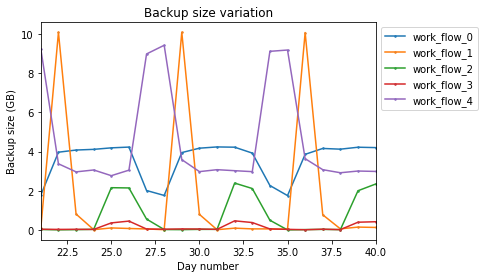

In [6]:
twenty = dataset.loc[dataset['Day #'] >= 21]
twenty = twenty.loc[twenty['Day #'] <= 40]
plot_dataset(twenty)

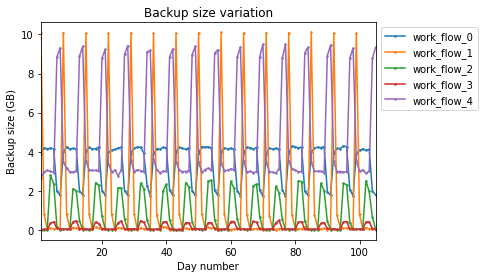

In [7]:
first105 = dataset.loc[dataset['Day #'] <= 105]
plot_dataset(first105)

<h2>Question 2 - a</h2>

In [10]:
df = dataset.replace({'Day of Week': {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5,
                                  'Saturday': 6, 'Sunday': 7},
                  'Work-Flow-ID': {'work_flow_0': 0, 'work_flow_1': 1, 'work_flow_2': 2, 'work_flow_3': 3,
                                   'work_flow_4': 4},
                  'File Name': {'File_0': 0, 'File_1': 1, 'File_2': 2, 'File_3': 3, 'File_4': 4, 'File_5': 5,
                                'File_6': 6, 'File_7': 7, 'File_8': 8, 'File_9': 9, 'File_10': 10, 'File_11': 11,
                                'File_12': 12, 'File_13': 13, 'File_14': 14, 'File_15': 15, 'File_16': 16,
                                'File_17': 17, 'File_18': 18, 'File_19': 19, 'File_20': 20, 'File_21': 21,
                                'File_22': 22,
                                'File_23': 23, 'File_24': 24, 'File_25': 25, 'File_26': 26, 'File_27': 27,
                                'File_28': 28, 'File_29': 29, }})

In [11]:
df.head()

,Week #,Day of Week,Backup Start Time - Hour of Day,Work-Flow-ID,File Name,Size of Backup (GB),Backup Time (hour),Day #
0,1,1,1,0,0,0.0,0,1
1,1,1,1,2,12,0.0,0,1
2,1,1,1,2,13,0.0,0,1
3,1,1,1,2,14,0.0,0,1
4,1,1,1,2,16,0.0,0,1


In [12]:
X = df[
    ['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']].values
y = df['Size of Backup (GB)'].values

### Part i

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print ("Coefficients:", linreg.coef_)
print ("Intercept:", linreg.intercept_)
y_predict = linreg.predict(X_test)
print("RMSE without cross validation:", np.sqrt(mean_squared_error(y_test, y_predict)))

Coefficients: [ -4.46137250e-05  -2.40527826e-03   1.38306408e-03  -4.14520552e-04
   4.85929375e-04]
Intercept: 0.049413880522
RMSE without cross validation: 0.106503866998


In [5]:
def perform_10fold(X,y,regressor, print_ = False,shuffle_= True):
    kf = KFold(n_splits=10,shuffle=shuffle_, random_state=0)
    i = 1
    bestModel = None
    tr_e = 0
    ts_e = 0
    min_ts_e = 10
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train)
        train_preds = regressor.predict(X_train)
        test_preds = regressor.predict(X_test)
        test_error = mean_squared_error(y_test,test_preds)
        tr_e += mean_squared_error(y_train,train_preds)
        ts_e += test_error
        if(print_):
            print("Fold : ",i)
            print("Training RMSE : ",np.sqrt(mean_squared_error(y_train,train_preds)))
            print("Test RMSE : ",np.sqrt(test_error))
        if(test_error<min_ts_e):
            min_ts_e = test_error
            bestModel = regressor
        i = i+1
    return np.sqrt(tr_e/10),np.sqrt(ts_e/10), bestModel

In [6]:
def plot_graph(x,y,xlabel,ylabel,title):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x, y, color='#1976D2', lw=1, label=y,s=1)
    #plt.plot([y.min(), y.max()], [0,0], 'k--', lw=4)
    plt.show()

In [7]:
def plot_graph_time(y1,y2,y1label,y2label,ylabel,title):
    plt.title(title)
    plt.scatter(np.arange(y1.shape[0]), y1, color='#1976D2', label=y1label,s=1)
    plt.scatter(np.arange(y1.shape[0]), y2, color='r', label=y2label,s=1)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

In [17]:
regressor = LinearRegression()
avg_tr,avg_ts,bestModel = perform_10fold(X,y,regressor, print_ = True)
print("------------------------------")
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)

Fold :  1
Training RMSE :  0.103265021252
Test RMSE :  0.106503866998
Fold :  2
Training RMSE :  0.103428926322
Test RMSE :  0.105029409306
Fold :  3
Training RMSE :  0.101891490799
Test RMSE :  0.117793845398
Fold :  4
Training RMSE :  0.104325747394
Test RMSE :  0.0967244993663
Fold :  5
Training RMSE :  0.104118712604
Test RMSE :  0.0987136373113
Fold :  6
Training RMSE :  0.104606731957
Test RMSE :  0.0939770759809
Fold :  7
Training RMSE :  0.103710941139
Test RMSE :  0.102543127434
Fold :  8
Training RMSE :  0.102680720217
Test RMSE :  0.111465416023
Fold :  9
Training RMSE :  0.103622312889
Test RMSE :  0.103306632317
Fold :  10
Training RMSE :  0.104198598987
Test RMSE :  0.0979498611003
------------------------------
Average Training RMSE :  0.103587856885
Average Test RMSE :  0.103627896737


In [18]:
regressor = LinearRegression()
regressor.fit(X,y)
predicted = regressor.predict(X)

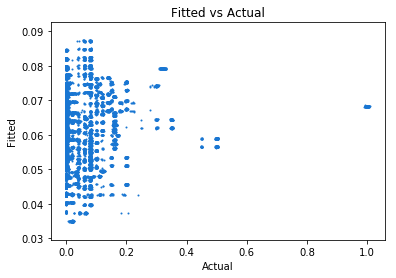

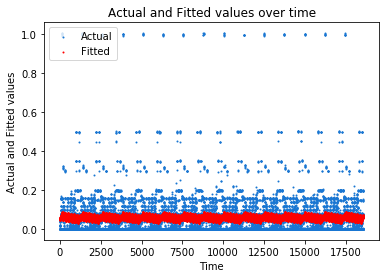

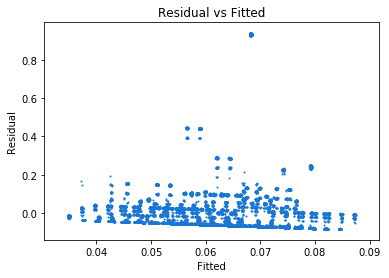

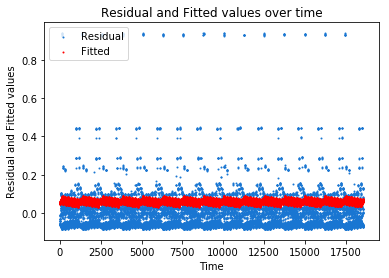

In [19]:
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

### Part ii

In [18]:
X = df[
    ['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']].values
y = df['Size of Backup (GB)'].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state = 0)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
linreg = LinearRegression()
linreg.fit(X_train_std, y_train)
print ("Coefficients:", linreg.coef_)
print ("Intercept:", linreg.intercept_)
y_predict = linreg.predict(X_test_std)
print("RMSE without cross validation:", np.sqrt(mean_squared_error(y_test, y_predict)))

Coefficients: [-0.00019274 -0.00479403  0.00944936 -0.00058665  0.00420832]
Intercept: 0.0607646798087
RMSE without cross validation: 0.106503866998


/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
def perform_10fold_std(X,y,regressor):
    kf = KFold(n_splits=10, shuffle=True, random_state = 0)
    i = 1
    bestModel = None
    tr_e = 0
    ts_e = 0
    min_ts_e = 10
    for train_index, test_index in kf.split(X):
        print("Fold : ",i)
        scaler = StandardScaler()
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)
        regressor.fit(X_train_std,y_train)
        train_preds = regressor.predict(X_train_std)
        test_preds = regressor.predict(X_test_std)
        test_error = mean_squared_error(y_test,test_preds)
        tr_e += mean_squared_error(y_train,train_preds)
        ts_e += test_error
        print("Training RMSE : ",np.sqrt(mean_squared_error(y_train,train_preds)))
        print("Test RMSE : ",np.sqrt(test_error))
        if(test_error<min_ts_e):
            min_ts_e = test_error
            bestModel = regressor
        i = i+1
    return np.sqrt(tr_e/10),np.sqrt(ts_e/10), bestModel

In [21]:
regressor = LinearRegression()
avg_tr,avg_ts,bestModel = perform_10fold_std(X,y,regressor)
print("------------------------------")
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)

/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Fold :  1
Training RMSE :  0.103265021252
Test RMSE :  0.106503866998
Fold :  2
Training RMSE :  0.103428926322
Test RMSE :  0.105029409306
Fold :  3
Training RMSE :  0.101891490799
Test RMSE :  0.117793845398
Fold :  4
Training RMSE :  0.104325747394
Test RMSE :  0.0967244993663
Fold :  5
Training RMSE :  0.104118712604
Test RMSE :  0.0987136373113
Fold :  6
Training RMSE :  0.104606731957
Test RMSE :  0.0939770759809
Fold :  7
Training RMSE :  0.103710941139
Test RMSE :  0.102543127434
Fold :  8
Training RMSE :  0.102680720217
Test RMSE :  0.111465416023
Fold :  9
Training RMSE :  0.103622312889
Test RMSE :  0.103306632317
Fold :  10
Training RMSE :  0.104198598987
Test RMSE :  0.0979498611003
------------------------------
Average Training RMSE :  0.103587856885
Average Test RMSE :  0.103627896737


In [24]:
scaler = StandardScaler()
X2 = scaler.fit_transform(X)
regressor.fit(X2,y)
predicted = regressor.predict(X2)

C:\Users\shivu.soman\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


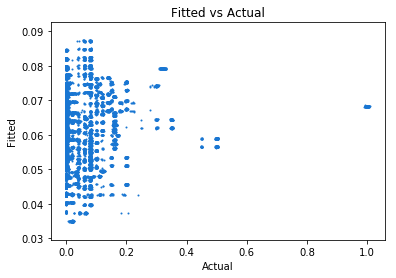

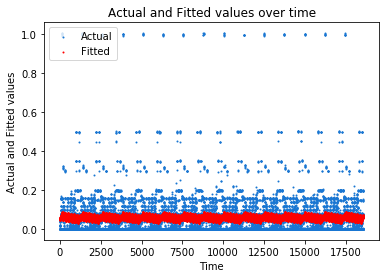

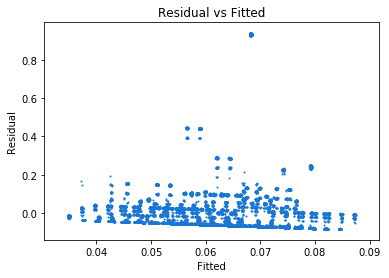

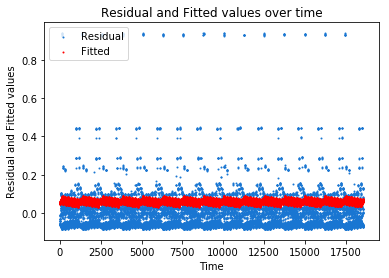

In [25]:
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

### Part iii

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,mutual_info_regression

In [25]:
X = df[
    ['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']].values
y = df['Size of Backup (GB)'].values

In [26]:
selectbest = SelectKBest(f_regression,k=3)
X_f = selectbest.fit_transform(X, y)
selectbest.scores_

array([  8.45006257e-03,   3.88163798e+01,   1.50740934e+02,
         2.61386654e+01,   2.53200943e+01])

#### Best features from f_regression = Day of the week, Backup time - hour of day, workflow id

In [27]:
selectbest2 = SelectKBest(mutual_info_regression,k=3)
X_mi = selectbest2.fit_transform(X, y)
selectbest2.scores_

/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


array([ 0.00313339,  0.2271637 ,  0.23895027,  0.27668999,  0.43091928])

#### Best features from mutual_info_regression = Backup time - hour of day, workflow id, file name

In [28]:
regressor = LinearRegression()
avg_tr,avg_ts,bestModel_f = perform_10fold(X_f,y,regressor, True)
print("------------------------------")
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)

Fold :  1
Training RMSE :  0.103268532787
Test RMSE :  0.106443895977
Fold :  2
Training RMSE :  0.103428949651
Test RMSE :  0.105028305966
Fold :  3
Training RMSE :  0.101892287775
Test RMSE :  0.117784174187
Fold :  4
Training RMSE :  0.104326006712
Test RMSE :  0.0967192474504
Fold :  5
Training RMSE :  0.104119294498
Test RMSE :  0.0987042824596
Fold :  6
Training RMSE :  0.104606957895
Test RMSE :  0.0939729611901
Fold :  7
Training RMSE :  0.103711829314
Test RMSE :  0.102521903924
Fold :  8
Training RMSE :  0.102682312458
Test RMSE :  0.111434749983
Fold :  9
Training RMSE :  0.103623435712
Test RMSE :  0.103290264859
Fold :  10
Training RMSE :  0.104198979884
Test RMSE :  0.0979443610377
------------------------------
Average Training RMSE :  0.103588792478
Average Test RMSE :  0.103611218666


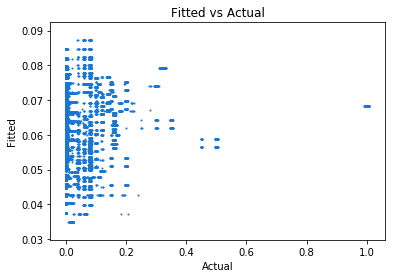

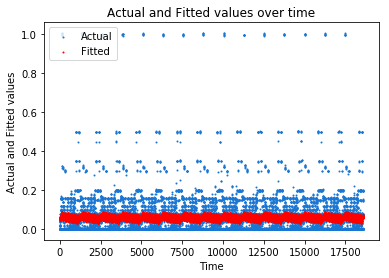

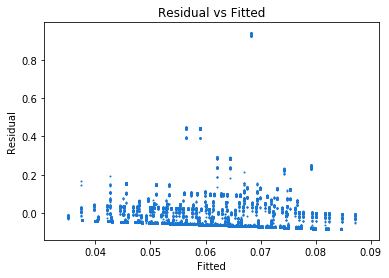

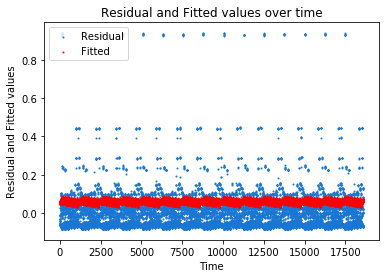

In [29]:
regressor.fit(X_f,y)
predicted = regressor.predict(X_f)
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

In [30]:
regressor = LinearRegression()
avg_tr,avg_ts,bestModel_mi = perform_10fold(X_mi,y,regressor, True)
print("------------------------------")
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)

Fold :  1
Training RMSE :  0.103376399889
Test RMSE :  0.106584984656
Fold :  2
Training RMSE :  0.103536556249
Test RMSE :  0.105145558744
Fold :  3
Training RMSE :  0.101981401227
Test RMSE :  0.118039036404
Fold :  4
Training RMSE :  0.104433193021
Test RMSE :  0.0968436314645
Fold :  5
Training RMSE :  0.104235472414
Test RMSE :  0.0987389195873
Fold :  6
Training RMSE :  0.104743818216
Test RMSE :  0.0937778764769
Fold :  7
Training RMSE :  0.103791140701
Test RMSE :  0.102876076128
Fold :  8
Training RMSE :  0.102796740173
Test RMSE :  0.111511031697
Fold :  9
Training RMSE :  0.103726952957
Test RMSE :  0.103446129396
Fold :  10
Training RMSE :  0.104320676685
Test RMSE :  0.0979227774242
------------------------------
Average Training RMSE :  0.103697228859
Average Test RMSE :  0.103720626763


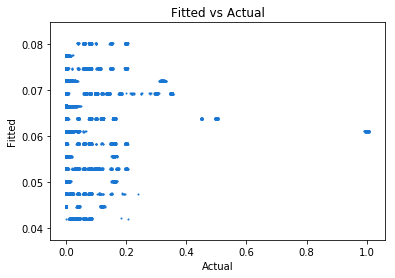

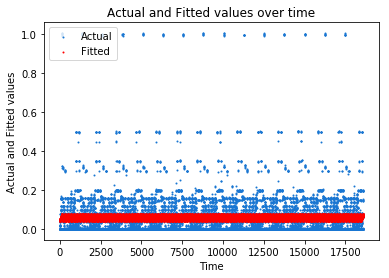

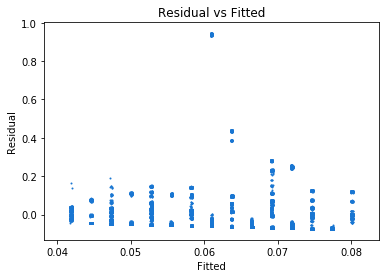

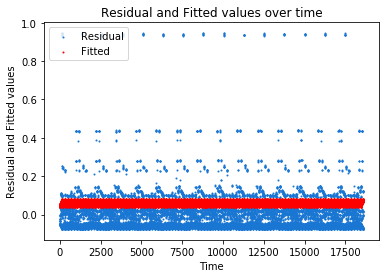

In [31]:
regressor.fit(X_mi,y)
predicted = regressor.predict(X_mi)
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

### Part iv

In [26]:
mask = []
for i in range(0,6):
    for j in itertools.combinations([0,1,2,3,4],i):
        mask_temp = [False,False,False,False,False]
        for index in j:
            mask_temp[index] = True
        mask.append(mask_temp)

#### with shuffle = True 

In [28]:
#Without one hot encoding
tr_l = []
ts_l = []
print("Encoding : ",mask[0])
regressor = LinearRegression()
avg_tr,avg_ts,bestModel = perform_10fold(X,y,regressor)
tr_l.append(avg_tr)
ts_l.append(avg_ts)
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)
#predicted = bestModel.predict(X)
#plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
#plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")
min_ts_e = avg_ts
bestModel_all = bestModel
best_mask = mask[0]
comb_num = 0
#with one hot encoding
for i in range(1,32):
    print("##############################")
    print("Encoding : ",mask[i])
    encoder = OneHotEncoder(categorical_features = mask[i])
    X_encoded = encoder.fit_transform(X).toarray()
    regressor = LinearRegression()
    avg_tr,avg_ts,bestModel = perform_10fold(X_encoded,y,regressor)
    tr_l.append(avg_tr)
    ts_l.append(avg_ts)
    print("Average Training RMSE : ",avg_tr)
    print("Average Test RMSE : ",avg_ts)
    #predicted = bestModel.predict(X_encoded)
    #plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
    #plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
    #plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
    #plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")
    if(avg_ts<min_ts_e):
            min_ts_e = avg_ts
            min_tr_e = avg_tr
            bestModel_all = bestModel
            best_mask = mask[i]
            comb_num = i
print("--------------------------------")
print("Best Combination : ",best_mask)
print("Combination Number : ",comb_num)
print("Training RMSE : ",min_tr_e)
print("Test RMSE : ",min_ts_e)
#print("Coefficients : ",bestModel_all.coef_)
#print("Intercept : ",bestModel_all.intercept_)

Encoding :  [False, False, False, False, False]
Average Training RMSE :  0.103587856885
Average Test RMSE :  0.103627896737
##############################
Encoding :  [True, False, False, False, False]
Average Training RMSE :  0.103583479817
Average Test RMSE :  0.103728724934
##############################
Encoding :  [False, True, False, False, False]
Average Training RMSE :  0.102152314879
Average Test RMSE :  0.10222295559
##############################
Encoding :  [False, False, True, False, False]
Average Training RMSE :  0.102362130777
Average Test RMSE :  0.102452283661
##############################
Encoding :  [False, False, False, True, False]
Average Training RMSE :  0.0913449367117
Average Test RMSE :  0.0913881375246
##############################
Encoding :  [False, False, False, False, True]
Average Training RMSE :  0.0913355555358
Average Test RMSE :  0.0915374105331
##############################
Encoding :  [True, True, False, False, False]
Average Training RMSE :  0

In [29]:
for i in range(0,32) :
    if ts_l[i] > 1:
        ts_l[i] = 1

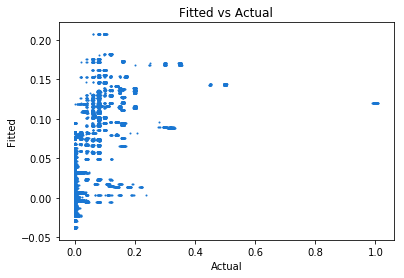

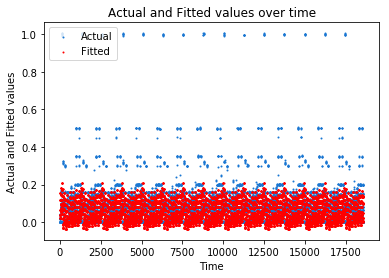

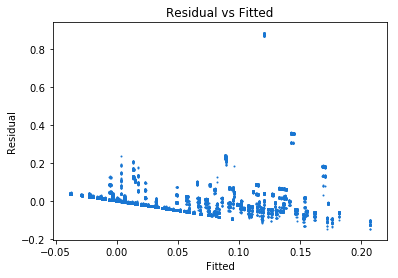

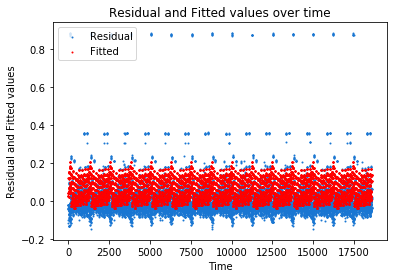

In [36]:
encoder = OneHotEncoder(categorical_features = [False, True, True, True, False])
X_encoded = encoder.fit_transform(X).toarray()
regressor.fit(X_encoded,y)
predicted = regressor.predict(X_encoded)
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

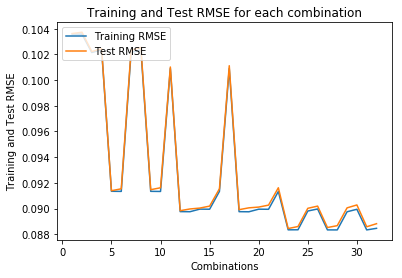

In [31]:
plt.title("Training and Test RMSE for each combination")
plt.plot(range(1,33), tr_l, label="Training RMSE")
plt.plot(range(1,33), ts_l, label='Test RMSE')
plt.legend(loc = 'upper left')
plt.xlabel("Combinations")
plt.ylabel("Training and Test RMSE")
plt.show()

#### with shufle = False

In [38]:
#Without one hot encoding
tr_l = []
ts_l = []
print("Encoding : ",mask[0])
regressor = LinearRegression()
avg_tr,avg_ts,bestModel = perform_10fold(X,y,regressor,shuffle_ = False)
tr_l.append(avg_tr)
ts_l.append(avg_ts)
print("Average Training RMSE : ",avg_tr)
print("Average Test RMSE : ",avg_ts)
#predicted = bestModel.predict(X)
#plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
#plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")
min_ts_e = avg_ts
bestModel_all = bestModel
best_mask = mask[0]
comb_num = 0
#with one hot encoding
for i in range(1,32):
    print("##############################")
    print("Encoding : ",mask[i])
    encoder = OneHotEncoder(categorical_features = mask[i])
    X_encoded = encoder.fit_transform(X).toarray()
    regressor = LinearRegression()
    avg_tr,avg_ts,bestModel = perform_10fold(X_encoded,y,regressor,shuffle_ = False)
    tr_l.append(avg_tr)
    ts_l.append(avg_ts)
    print("Average Training RMSE : ",avg_tr)
    print("Average Test RMSE : ",avg_ts)
    print("Coefficients : ",bestModel.coef_)
    #predicted = bestModel.predict(X_encoded)
    #plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
    #plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
    #plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
    #plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")
    if(avg_ts<min_ts_e):
            min_ts_e = avg_ts
            min_tr_e = avg_tr
            bestModel_all = bestModel
            best_mask = mask[i]
            comb_num = i
print("--------------------------------")
print("Best Combination : ",best_mask)
print("Combination Number : ",comb_num)
print("Training RMSE : ",min_tr_e)
print("Test RMSE : ",min_ts_e)
#print("Coefficients : ",bestModel_all.coef_)
#print("Intercept : ",bestModel_all.intercept_)

Encoding :  [False, False, False, False, False]
Average Training RMSE :  0.103585393643
Average Test RMSE :  0.103675847676
##############################
Encoding :  [True, False, False, False, False]
Average Training RMSE :  0.103580519421
Average Test RMSE :  9557766082.57
Coefficients :  [  1.55919232e+10   1.55919232e+10   1.55919232e+10   1.55919232e+10
   1.55919232e+10   1.55919232e+10   1.55919232e+10   1.55919232e+10
   1.55919232e+10   1.55919232e+10   1.55919232e+10   1.55919232e+10
   1.55919232e+10   1.55919232e+10   7.84428124e-11  -2.55424654e-03
   1.38718125e-03   2.06405249e-03  -2.72095868e-06]
##############################
Encoding :  [False, True, False, False, False]
Average Training RMSE :  0.10215359608
Average Test RMSE :  0.102252844789
Coefficients :  [  3.99107122e-02  -1.32222361e-02  -2.04232090e-02  -5.73594384e-03
  -5.13812682e-03   3.21834910e-03   1.39045443e-03   1.09857956e-05
   1.40628001e-03   2.10140506e-03  -4.04339813e-07]
##################

Average Training RMSE :  0.0913384812944
Average Test RMSE :  0.0914979826784
Coefficients :  [  1.62763750e+11   4.10943003e+10   1.21038022e+11   5.34600555e+10
   4.30253083e+10  -8.10958924e+10  -8.10958924e+10  -8.10958924e+10
  -8.10958924e+10  -8.10958924e+10  -8.10958924e+10   4.05735577e+10
   4.05735577e+10   4.05735577e+10   4.05735577e+10   4.05735577e+10
   4.05735577e+10  -3.93701641e+10  -3.93701641e+10  -3.93701641e+10
  -3.93701641e+10  -3.93701641e+10  -3.93701641e+10   2.82078025e+10
   2.82078025e+10   2.82078025e+10   2.82078025e+10   2.82078025e+10
   2.82078025e+10   3.86425497e+10   3.86425497e+10   3.86425497e+10
   3.86425497e+10   3.86425497e+10   3.86425497e+10  -4.57763672e-05
  -2.56347656e-03   1.43432617e-03]
##############################
Encoding :  [True, True, True, False, False]
Average Training RMSE :  0.100938689838
Average Test RMSE :  15971230702.0
Coefficients :  [  2.32481023e+10   2.32481023e+10   2.32481023e+10   2.32481023e+10
   2.32481023

Average Training RMSE :  0.08994912226
Average Test RMSE :  0.0901232818935
Coefficients :  [ -3.21809343e+08  -3.21809343e+08  -3.21809343e+08  -3.21809342e+08
  -3.21809343e+08  -3.21809343e+08   8.76427173e+07   3.50240290e+09
  -1.48439300e+07   7.11298238e+08  -1.53408048e+09   2.38455079e+08
   2.38455079e+08   2.38455079e+08   2.38455079e+08   2.38455079e+08
   2.38455079e+08  -3.17630510e+09  -3.17630510e+09  -3.17630510e+09
  -3.17630510e+09  -3.17630510e+09  -3.17630510e+09   3.40941726e+08
   3.40941726e+08   3.40941726e+08   3.40941726e+08   3.40941726e+08
   3.40941726e+08  -3.85200442e+08  -3.85200442e+08  -3.85200442e+08
  -3.85200442e+08  -3.85200442e+08  -3.85200442e+08   1.86017827e+09
   1.86017827e+09   1.86017827e+09   1.86017827e+09   1.86017827e+09
   1.86017827e+09  -4.25577164e-05  -2.45046616e-03]
##############################
Encoding :  [True, True, True, True, False]
Average Training RMSE :  0.0883383047029
Average Test RMSE :  16236872626.1
Coefficients :

In [33]:
for i in range(0,32) :
    if ts_l[i] > 1:
        ts_l[i] = 1

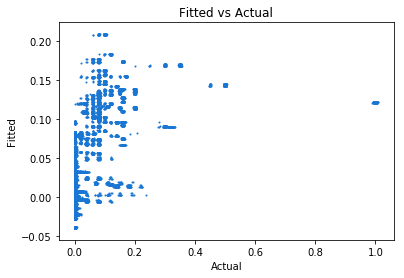

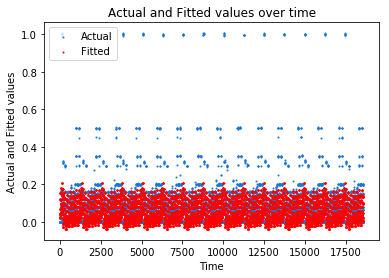

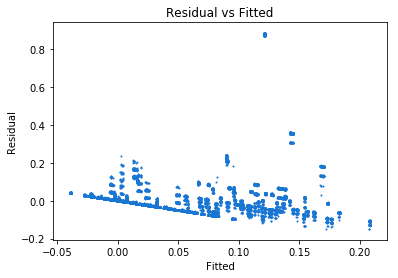

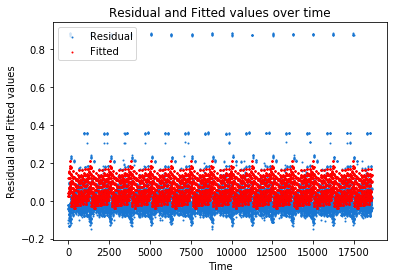

In [34]:
encoder = OneHotEncoder(categorical_features = [False, True, True, False, True])
X_encoded = encoder.fit_transform(X).toarray()
regressor.fit(X_encoded,y)
predicted = regressor.predict(X_encoded)
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

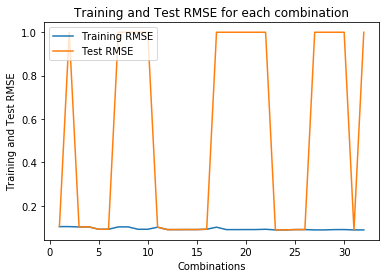

In [35]:
plt.title("Training and Test RMSE for each combination")
plt.plot(range(1,33), tr_l, label="Training RMSE")
plt.plot(range(1,33), ts_l, label='Test RMSE')
plt.legend(loc = 'upper left')
plt.xlabel("Combinations")
plt.ylabel("Training and Test RMSE")
plt.show()

### Part v

In [41]:
new_ridge = Ridge()
new_lasso = Lasso()
new_elasticnet = ElasticNet()

In [44]:
params = []
def partv(regressor,parameters):
    best_score = 10
    for i in range(1,32):
        print("##############################")
        print("Encoding : ",mask[i])
        encoder = OneHotEncoder(categorical_features = mask[i])
        X_encoded = encoder.fit_transform(X).toarray()
        clf = GridSearchCV(regressor, parameters, cv=10,scoring = 'neg_mean_squared_error')
        clf.fit(X_encoded,y)
        score = np.sqrt(-1 * clf.best_score_)
        print("Best Parameter : ",clf.best_params_)
        print("RMSE : ", score)
        params.append(clf.best_params_)
        if mask[i][0] == True:
            print("Coefficients : ",clf.best_estimator_.coef_)
        if score < best_score:
            best_score = score
            best_param = clf.best_params_
            best_estimator = clf.best_estimator_
            best_mask = mask[i]
    print("---------------------------")
    print("Best Combination : ",best_mask)
    print("Parameter : ",best_param)
    print("Test RMSE : ",best_score)
    print("Coefficients : ",best_estimator.coef_)
    print("Intercept : ",best_estimator.intercept_)

In [45]:
parameters = {'alpha':[0.0001,0.001,0.1,1,10,100,1000,10000]}
partv(new_ridge,parameters)

##############################
Encoding :  [True, False, False, False, False]
Best Parameter :  {'alpha': 10000}
RMSE :  0.103673664218
Coefficients :  [ -9.45768729e-05  -4.59194853e-06   4.11115956e-05  -3.61687311e-05
   2.40866466e-05  -3.09779684e-05  -1.47931536e-06   9.33124818e-05
   1.63625580e-05   2.09626080e-05  -5.54183186e-05   7.24534016e-05
  -2.27628441e-05   1.22038092e-06  -2.35336736e-05  -2.09482454e-03
   1.35150870e-03   3.54881809e-04   3.70103836e-04]
##############################
Encoding :  [False, True, False, False, False]
Best Parameter :  {'alpha': 10}
RMSE :  0.102231852837
##############################
Encoding :  [False, False, True, False, False]
Best Parameter :  {'alpha': 10}
RMSE :  0.102465499369
##############################
Encoding :  [False, False, False, True, False]
Best Parameter :  {'alpha': 10}
RMSE :  0.0914970533256
##############################
Encoding :  [False, False, False, False, True]
Best Parameter :  {'alpha': 1}
RMSE :  0.

Best Parameter :  {'alpha': 100}
RMSE :  0.0915844182216
Coefficients :  [ -7.51884533e-04  -2.43150644e-05   3.26815245e-04  -3.21606544e-04
   3.06610643e-04  -2.18847245e-04  -1.61939839e-06   7.64800376e-04
   1.19514335e-04   1.29038981e-04  -5.12687890e-04   6.47277230e-04
  -1.80118529e-04  -7.93089402e-06  -2.75046711e-04   3.24215248e-02
  -1.17725139e-02  -3.37354955e-02  -4.78743107e-02   6.09607953e-02
   4.77493755e-03   5.87028451e-03   5.56612046e-03   5.54332969e-03
   5.20740857e-03   5.45944397e-03  -1.63125059e-03  -2.04582837e-03
  -1.86692792e-03  -2.10998740e-03  -2.19979445e-03  -1.91872514e-03
  -6.31926393e-03  -5.87490713e-03  -5.46677427e-03  -6.40806152e-03
  -4.26033358e-03  -5.40615505e-03  -8.11770129e-03  -7.83542263e-03
  -7.78461474e-03  -8.09498402e-03  -8.13693152e-03  -7.90465651e-03
   9.93583628e-03   1.04220624e-02   1.05856003e-02   9.66541464e-03
   1.02230156e-02   1.01288661e-02  -2.43090385e-03   1.37775404e-03]
#############################

In [67]:
parameters = {'alpha':[0.0001,0.001,0.1,1,10,100,1000,10000]}
partv(new_lasso,parameters)

##############################
Encoding :  [True, False, False, False, False]
Best Parameter :  {'alpha': 0.001}
RMSE :  0.103671129332
Coefficients :  [-0.         -0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.         -0.          0.         -0.          0.
 -0.         -0.00212748  0.00134582  0.          0.00041619]
##############################
Encoding :  [False, True, False, False, False]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.102233153569
##############################
Encoding :  [False, False, True, False, False]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.102467016538
##############################
Encoding :  [False, False, False, True, False]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.0914981026218
##############################
Encoding :  [False, False, False, False, True]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.0915321257068
##############################
Encoding :  [True, True, False, False, False]
Best 

Best Parameter :  {'alpha': 0.0001}
RMSE :  0.0885087077711
Coefficients :  [ -0.00000000e+00  -0.00000000e+00   0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00   4.37514765e-02
  -6.96871724e-03  -1.44485200e-02  -0.00000000e+00  -0.00000000e+00
   7.71885795e-03   5.93837009e-03  -2.10325856e-02  -2.18485844e-02
   5.78380900e-03   3.14470601e-02  -2.79070210e-03   4.90387305e-06
   5.11006443e-02  -0.00000000e+00  -2.50093225e-02  -4.10421028e-02
   8.85037192e-02  -1.12788423e-04]
##############################
Encoding :  [True, True, True, False, True]
Best Parameter :  {'alpha': 0.0001}
RMSE :  0.0885436922198
Coefficients :  [-0.         -0.          0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.          0.         -0.         -0.
 -0.          0.04377614 -0.007

In [68]:
new_elasticnet = ElasticNet(max_iter = 10000)
parameters = {'alpha':[0.0001,0.001,0.1,1,10,100,1000,10000],'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}
partv(new_elasticnet,parameters)

##############################
Encoding :  [True, False, False, False, False]
Best Parameter :  {'alpha': 0.001, 'l1_ratio': 0.5}
RMSE :  0.103670353304
Coefficients :  [-0.         -0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.         -0.          0.         -0.          0.
 -0.         -0.00225255  0.00135664  0.          0.00042236]
##############################
Encoding :  [False, True, False, False, False]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.10223179185
##############################
Encoding :  [False, False, True, False, False]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.102465502253
##############################
Encoding :  [False, False, False, True, False]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.0914970673675
##############################
Encoding :  [False, False, False, False, True]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.091498284852

Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.0885041347576
##############################
Encoding :  [False, True, True, False, True]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.0885053449722
##############################
Encoding :  [False, True, False, True, True]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.0899070335508
##############################
Encoding :  [False, False, True, True, True]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.1}
RMSE :  0.0901241934421
##############################
Encoding :  [True, True, True, True, False]
Best Parameter :  {'alpha': 0.0001, 'l1_ratio': 0.5}
RMSE :  0.0885056435854
Coefficients :  [ -3.82963693e-05  -0.00000000e+00   0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00   7.73428489e-05
   0.00000000e+00   0.00000000e+00  -0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00   4.41872307e-02
  -7.24275411e-03  -

<h2>Question 2 - b</h2>

In [8]:
dataset = pd.read_csv('network_backup_dataset.csv')
dataset['Day #'] = (dataset['Week #'] - 1) * 7 + encode_day_names(dataset['Day of Week'])

In [9]:
def encode_datalist(datalist):
    encoding = {}
    for i in datalist:
        if i in encoding:
            continue
        else:
            encoding[i] = i.split('_')[-1]
    return [encoding[i] for i in datalist]

In [10]:
dataset_copy = dataset.copy()

In [11]:
# dataset_copy contains scalar encoding of features
dataset_copy['Day of Week'] = encode_day_names(dataset_copy['Day of Week'])
dataset_copy['File Name'] = encode_datalist(dataset_copy['File Name'])
dataset_copy['Work-Flow-ID'] = encode_datalist(dataset_copy['Work-Flow-ID'])

In [12]:
dataset_copy.head()

,Week #,Day of Week,Backup Start Time - Hour of Day,Work-Flow-ID,File Name,Size of Backup (GB),Backup Time (hour),Day #
0,1,1,1,0,0,0.0,0,1
1,1,1,1,2,12,0.0,0,1
2,1,1,1,2,13,0.0,0,1
3,1,1,1,2,14,0.0,0,1
4,1,1,1,2,16,0.0,0,1


<h2>Part i</h2>

In [15]:
regr = RandomForestRegressor(n_estimators=20, max_depth=4, max_features=5, bootstrap=True, oob_score=True, random_state=0)
X = dataset_copy.iloc[:,:5].values
y = dataset_copy.iloc[:,5].values
train_rmse, test_rmse, best_rfr = perform_10fold(X, y, regr, True)
print("------------------------------")
print("Average Training RMSE : ",train_rmse)
print("Average Test RMSE : ",test_rmse)

Fold :  1
Training RMSE :  0.0608127619351
Test RMSE :  0.0619482244824
Fold :  2
Training RMSE :  0.0601612297879
Test RMSE :  0.0596101321304
Fold :  3
Training RMSE :  0.0593906939253
Test RMSE :  0.0732624795145
Fold :  4
Training RMSE :  0.0601581367598
Test RMSE :  0.0523624583898
Fold :  5
Training RMSE :  0.0612088738697
Test RMSE :  0.0584266811175
Fold :  6
Training RMSE :  0.0616024645485
Test RMSE :  0.0533977390874
Fold :  7
Training RMSE :  0.0602120389363
Test RMSE :  0.0661703601722
Fold :  8
Training RMSE :  0.0602323586423
Test RMSE :  0.0670433518938
Fold :  9
Training RMSE :  0.0610613146866
Test RMSE :  0.0597004806742
Fold :  10
Training RMSE :  0.0599592436311
Test RMSE :  0.0524354241021
------------------------------
Average Training RMSE :  0.0604832481886
Average Test RMSE :  0.0607882493747


In [54]:
regr.fit(X,y)
print("OOB Score: ", regr.oob_score_)
print("OOB Error: ", 1-regr.oob_score_)

OOB Score:  0.656630223607
OOB Error:  0.343369776393


In [55]:
predicted = regr.predict(X)

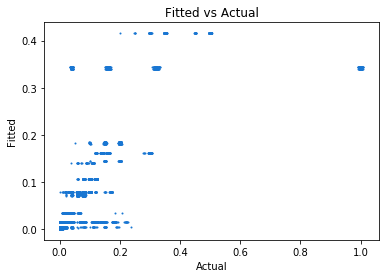

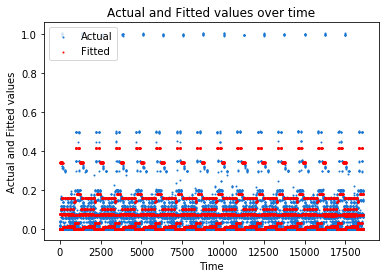

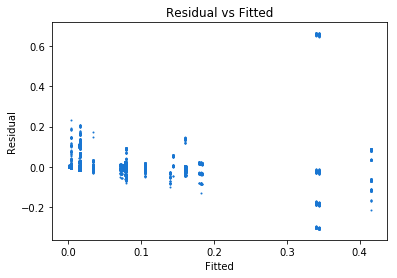

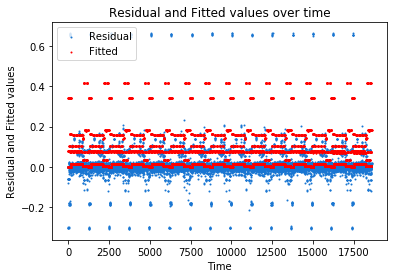

In [56]:
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

<h2>Part ii</h2>

In [13]:
def plot_func(i, x, oob, rmse, xlabel):
    print("Min OOB error at ",xlabel," : ", x[oob.index(min(oob))], "= ", min(oob))
    print("Min RMSE at ",xlabel," : ", x[rmse.index(min(rmse))], "= ",min(rmse))
    plt.plot(x, oob, label="OOB Error")
    plt.title("Max features: "+str(i))
    plt.legend()
    plt.xlabel(xlabel)
    plt.show()
    plt.title("Max features: "+str(i))
    plt.plot(x, rmse, color='#FB8C00', label='Test RMSE')
    plt.legend()
    plt.xlabel(xlabel)
    plt.show()

Max number of features:  1
Min OOB error at  # Trees  :  195 =  0.512762136272
Min RMSE at  # Trees  :  2 =  0.0698928915494


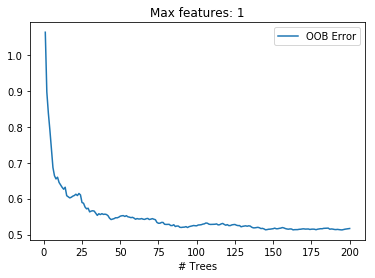

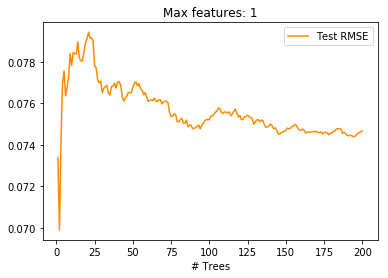

Max number of features:  2
Min OOB error at  # Trees  :  25 =  0.36287171125
Min RMSE at  # Trees  :  2 =  0.0597898399214


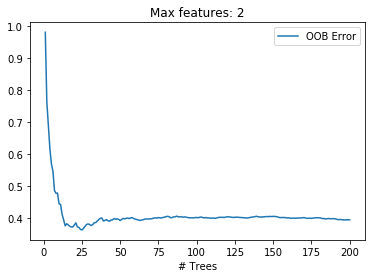

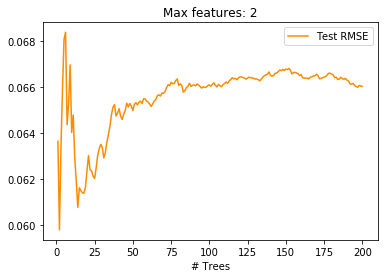

Max number of features:  3
Min OOB error at  # Trees  :  15 =  0.329047038553
Min RMSE at  # Trees  :  13 =  0.0581903685889


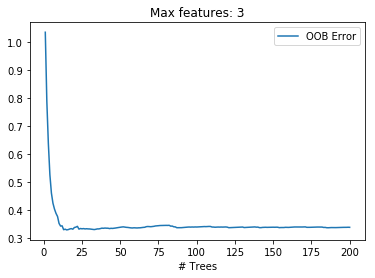

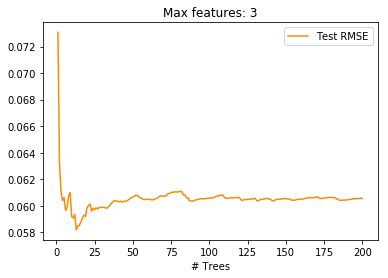

Max number of features:  4
Min OOB error at  # Trees  :  156 =  0.343816448266
Min RMSE at  # Trees  :  24 =  0.0608522551228


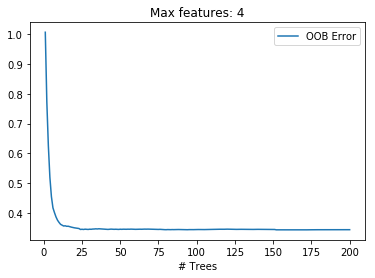

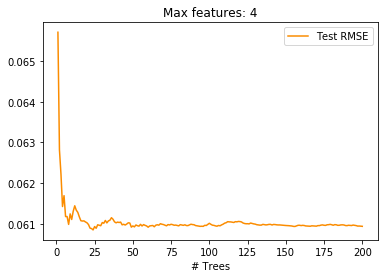

Max number of features:  5
Min OOB error at  # Trees  :  154 =  0.340599524776
Min RMSE at  # Trees  :  3 =  0.0604685995758


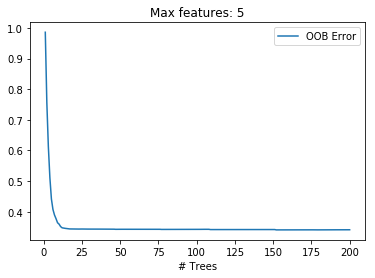

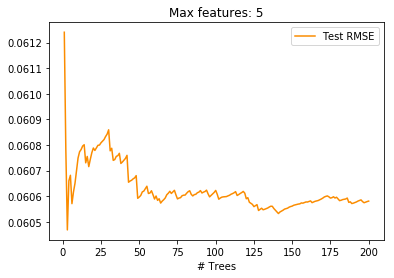

In [58]:
import warnings
warnings.filterwarnings('ignore')

trees = range(1,201)

for i in range(1,6):
    oob_errors = []
    test_rmse = []
    for t in trees:
        regr = RandomForestRegressor(n_estimators=t, max_depth=4, max_features=i, bootstrap=True, oob_score=True, random_state=0)
        train, test, best_rfr = perform_10fold(X, y, regr)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
        #regr.fit(X_train, y_train)
        #y_pred = regr.predict(X_test)
        regr.fit(X,y)
        oob_score = regr.oob_score_
        oob_error = 1 - oob_score
        oob_errors.append(oob_error)
        test_rmse.append(test)
        #test_error = mean_squared_error(y_test,y_pred)
        #test_rmse.append(np.sqrt(test_error))
    print("Max number of features: ",i)
    #plt.plot(trees, test_rmse)
    #plt.show()
    plot_func(i, trees, oob_errors, test_rmse, "# Trees")

<h2>Part iii</h2>

Max number of features:  1
Min OOB error at  Depths  :  None =  0.0603454204542
Min RMSE at  Depths  :  None =  0.0205093268258


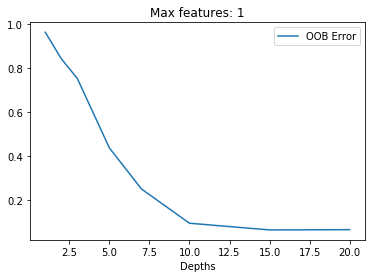

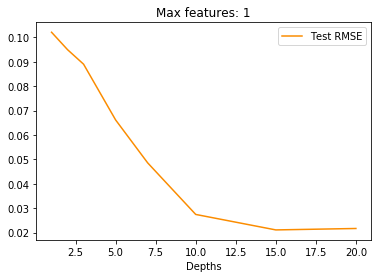

Max number of features:  2
Min OOB error at  Depths  :  20 =  0.0317060281505
Min RMSE at  Depths  :  15 =  0.0155427840928


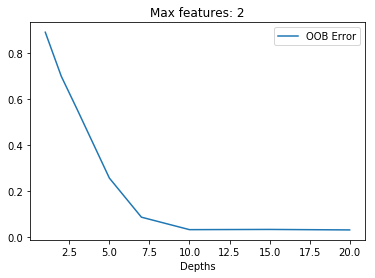

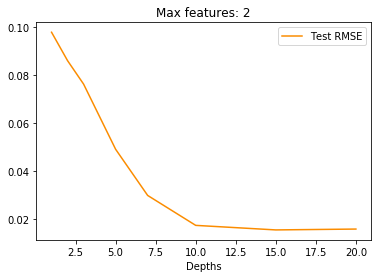

Max number of features:  3
Min OOB error at  Depths  :  10 =  0.0238662143006
Min RMSE at  Depths  :  10 =  0.0135374886247


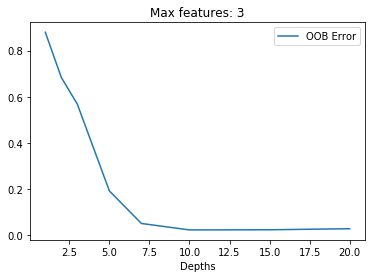

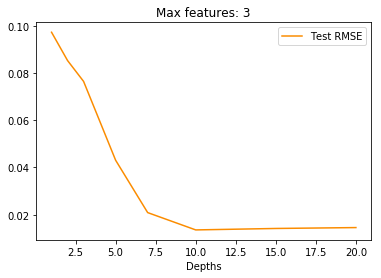

Max number of features:  4
Min OOB error at  Depths  :  10 =  0.018546384693
Min RMSE at  Depths  :  10 =  0.0129456923991


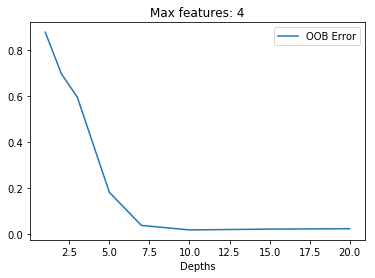

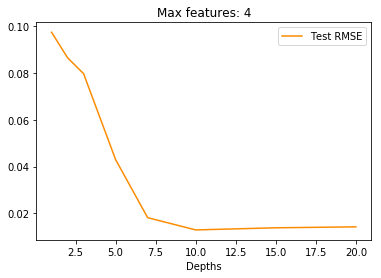

Max number of features:  5
Min OOB error at  Depths  :  10 =  0.018428083607
Min RMSE at  Depths  :  10 =  0.0129387656467


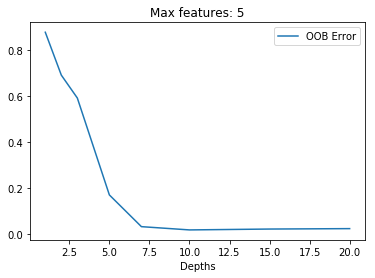

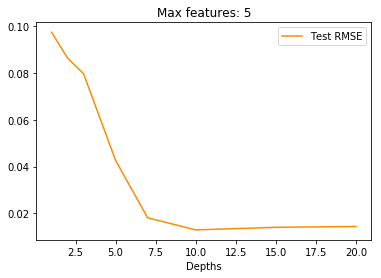

In [16]:
depths = [1,2,3, 5,7,10,15,20, None]
for i in range(1,6):
    oob_errors = []
    test_rmse = []
    for d in depths:
        regr = RandomForestRegressor(n_estimators=13, max_depth=d, max_features=i, bootstrap=True, oob_score=True, random_state=0)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
        #regr.fit(X_train, y_train)
        train, test, best_rfr = perform_10fold(X, y, regr)
        regr.fit(X,y)
        #y_pred = regr.predict(X_test)
        oob_score = regr.oob_score_
        oob_error = 1 - oob_score
        oob_errors.append(oob_error)
        test_rmse.append(test)
        #test_error = mean_squared_error(y_test,y_pred)
        #test_rmse.append(np.sqrt(test_error))
    print("Max number of features: ",i)
    plot_func(i, depths, oob_errors, test_rmse, "Depths")

<h2>Part iv</h2>

In [18]:
bestModel = RandomForestRegressor(n_estimators=13, max_depth=10, max_features=4, bootstrap=True, oob_score=True, random_state=0)
bestModel.fit(X,y)
train_rmse, test_rmse, best_rfr = perform_10fold(X, y, bestModel, True)
print("------------------------------")
print("Average Training RMSE : ",train_rmse)
print("Average Test RMSE : ",test_rmse)
print("------------------------------")
print("Feature importances")
print(bestModel.feature_importances_)
print(sorted(zip(map(lambda x: round(x, 4), bestModel.feature_importances_), dataset_copy.columns),
             reverse=True))

Fold :  1
Training RMSE :  0.0110443927527
Test RMSE :  0.0132719702798
Fold :  2
Training RMSE :  0.0111322904224
Test RMSE :  0.01301588779
Fold :  3
Training RMSE :  0.0111944530325
Test RMSE :  0.0123352139984
Fold :  4
Training RMSE :  0.0111532207252
Test RMSE :  0.0125999072471
Fold :  5
Training RMSE :  0.0111218496287
Test RMSE :  0.0131874992086
Fold :  6
Training RMSE :  0.0110816787088
Test RMSE :  0.0134846337558
Fold :  7
Training RMSE :  0.0111098204368
Test RMSE :  0.0136503476441
Fold :  8
Training RMSE :  0.0111630005812
Test RMSE :  0.0126503337368
Fold :  9
Training RMSE :  0.0111808534463
Test RMSE :  0.0128066718751
Fold :  10
Training RMSE :  0.0111699263433
Test RMSE :  0.0123821063621
------------------------------
Average Training RMSE :  0.0111352376946
Average Test RMSE :  0.0129456923991
------------------------------
Feature importances
[ 0.00329817  0.23573871  0.37311006  0.19559909  0.19225396]
[(0.37309999999999999, 'Backup Start Time - Hour of Day'), 

In [70]:
predicted = bestModel.predict(X)

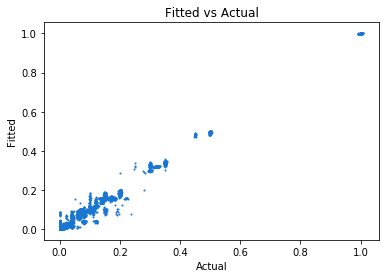

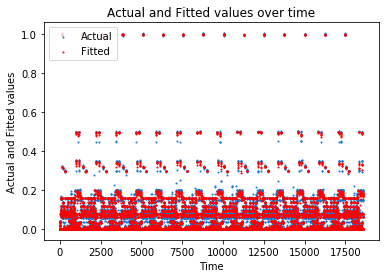

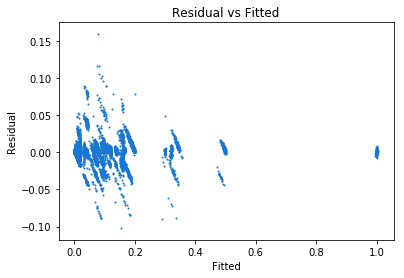

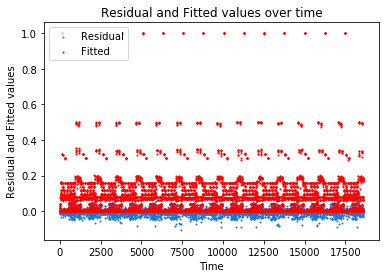

In [71]:
plot_graph(y,predicted,"Actual","Fitted","Fitted vs Actual")
plot_graph_time(y,predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
plot_graph(predicted,y-predicted,"Fitted","Residual","Residual vs Fitted")
plot_graph_time(y-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")

<h2>Part v</h2>

In [16]:
def plot_bar(importances, indices, features):
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='#42A5F5', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.show()

Visualizing feature importance for best model in Part iv


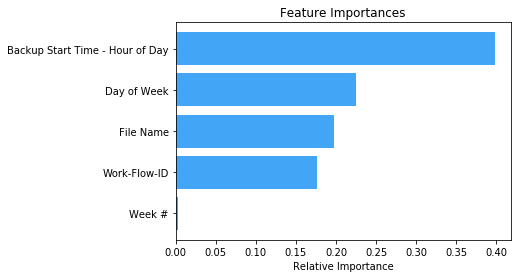

In [21]:
print("Visualizing feature importance for best model in Part iv")
bestModel = RandomForestRegressor(n_estimators=13, max_depth=10, max_features=4, bootstrap=True, oob_score=True, random_state=0)
bestModel.fit(X,y)
features = dataset_copy.columns[0:5]
importances = bestModel.feature_importances_
indices = np.argsort(importances)
plot_bar(importances, indices, features)

Visualizing feature importance for random forrest estimator with depth restricted to 4


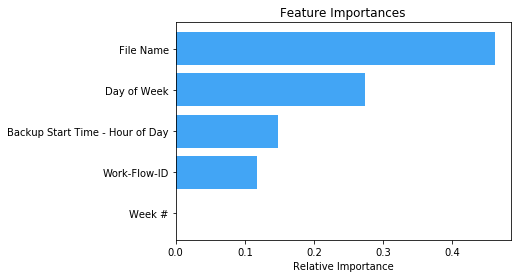

In [22]:
clf = bestModel.estimators_[3]
print("Visualizing feature importance for random forrest estimator with depth restricted to 4")
bestModel = RandomForestRegressor(n_estimators=13, max_depth=4, max_features=4, bootstrap=True, oob_score=True, random_state=0)
bestModel.fit(X,y)
clf = bestModel.estimators_[3]
features = dataset_copy.columns[0:5]
importances = clf.feature_importances_
indices = np.argsort(importances)
plot_bar(importances, indices, features)

Visualizing decision tree for random forrest estimator with depth restricted to 4


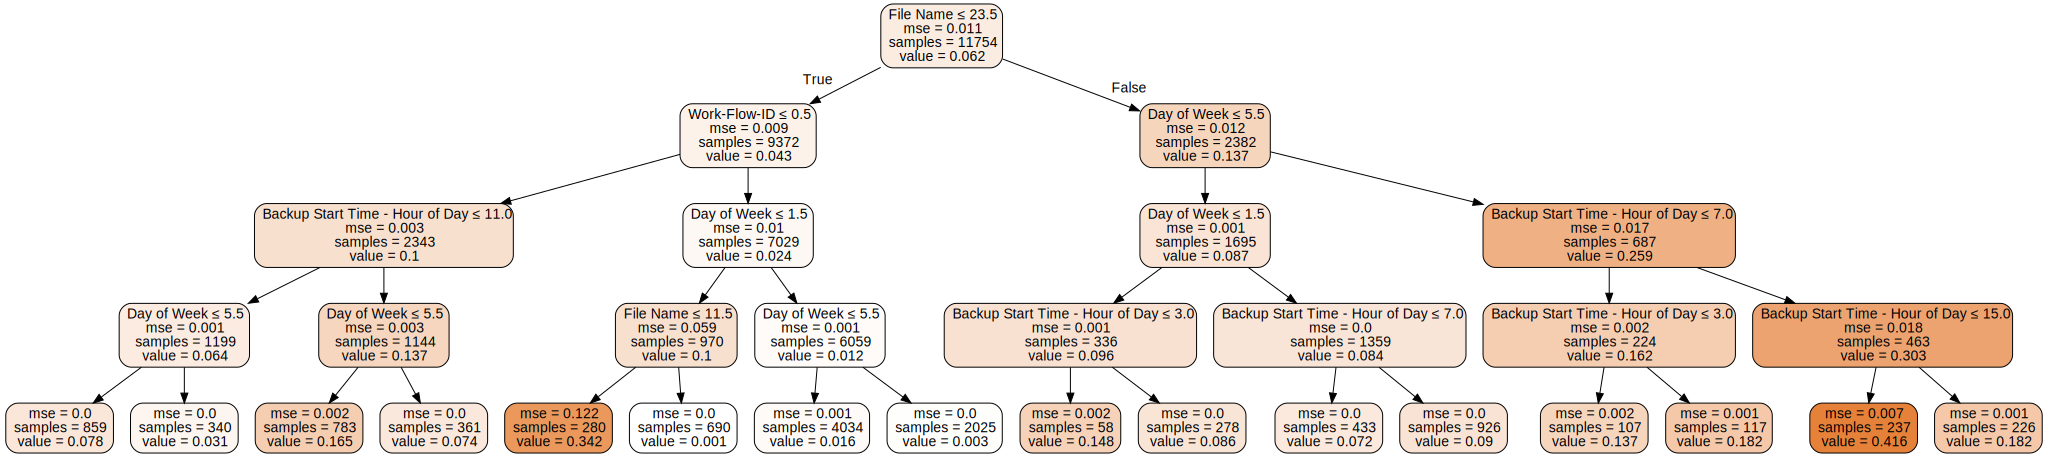

In [23]:
print("Visualizing decision tree for random forrest estimator with depth restricted to 4")
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,   
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 
graph 